In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

In [2]:
os.chdir('C:\\Users\\Hp\\OneDrive\\Documents\\GitHub\\Thoucentric\\DataSets')

In [3]:
cr_1=pd.read_csv('crude_close.csv')
cr_2=pd.read_csv('crude_open.csv')
cr_3=pd.read_csv('crude_low.csv')
cr_4=pd.read_csv('crude_high.csv')
cr_merged_1 = pd.merge(cr_1, cr_2, on='date')
cr_merged_2 = pd.merge(cr_merged_1, cr_3, on='date')
cr = pd.merge(cr_merged_2, cr_4, on='date')

Merge function combines dataframes with a parameter 'on' which defines the basis for the merge. Here we are merging on the basis of date which means that the final dataframe would have all rows having common dates. There are multiple ways of merging but the default is intersection of the dataframes.

In [4]:
df=pd.read_csv('Iceus_sugar_all.csv')
df=pd.merge(df, cr, on='date')
df.head()

,date,low,high,close,open,cr_close,cr_open,cr_low,cr_high
0,2017-01-03T00:00:00.000Z,19.58,20.55,20.51,19.63,56.46,57.05,55.30,58.37
1,2017-01-04T00:00:00.000Z,20.41,20.94,20.89,20.55,56.89,55.73,55.33,56.55
2,2017-01-05T00:00:00.000Z,20.66,21.18,20.78,20.89,57.10,56.35,56.01,57.35
3,2017-01-06T00:00:00.000Z,20.30,20.84,20.75,20.66,57.10,56.88,56.28,57.47
4,2017-01-09T00:00:00.000Z,20.36,20.75,20.42,20.74,53.64,56.81,54.74,57.00


Set date to date format form a string format


In [5]:
train_dates=pd.to_datetime(df['date'])

Take all columns except date as X features 

In [6]:
X=df.iloc[:, 1:8]

In [7]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

We set how many days of prediction we do while taking into account how many past days. Here, we calculate any 1 day from previous 14 days of data

In [8]:
train_X=[]
train_y=[]
n_future=1
n_past=14
for i in range(n_past, len(X) - n_future + 1):
    train_X.append(X[i-n_past:i, 0:X.shape[1]])         #understand this exactly
    train_y.append(X[i+n_future-1:i+n_future, 0])       #undersatnd this exactly
train_X, train_y = np.array(train_X), np.array(train_y)
train_X.shape, train_y.shape

((1768, 14, 7), (1768, 1))

When setting up the LSTM model, when we use multiple LSTM layers, we use another parameter 'return_sequences' which tells the model to return the output of the first LSTM layer to the next layer as input in the form of a sequence as LSTM requices sequential data. 

In [9]:
model=Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18432     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


In [10]:
history=model.fit(train_X, train_y, epochs=40, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/40
100/100 [==============================] - 4s 16ms/step - loss: 0.1271 - val_loss: 0.0198
Epoch 2/40
100/100 [==============================] - 1s 12ms/step - loss: 0.0477 - val_loss: 0.0177
Epoch 3/40
100/100 [==============================] - 1s 14ms/step - loss: 0.0373 - val_loss: 0.0148
Epoch 4/40
100/100 [==============================] - 1s 12ms/step - loss: 0.0372 - val_loss: 0.0125
Epoch 5/40
100/100 [==============================] - 1s 12ms/step - loss: 0.0365 - val_loss: 0.0134
Epoch 6/40
100/100 [==============================] - 1s 12ms/step - loss: 0.0327 - val_loss: 0.0124
Epoch 7/40
100/100 [==============================] - 1s 12ms/step - loss: 0.0332 - val_loss: 0.0102
Epoch 8/40
100/100 [==============================] - 1s 12ms/step - loss: 0.0324 - val_loss: 0.0109
Epoch 9/40
100/100 [==============================] - 1s 11ms/step - loss: 0.0294 - val_loss: 0.0082
Epoch 10/40
100/100 [==============================] - 1s 12ms/step - loss: 0.0300 - val_lo

In [11]:
def compute_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    bias = np.mean(predicted - actual)
    variance = np.var(predicted - actual)

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2,
        'Bias': bias,
        'Variance': variance
    }
    
    return metrics

In [21]:
train_predictions = model.predict(train_X).flatten()
ytrain1= train_y.flatten()
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals': ytrain1})
train_results

56/56 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,0.556407,0.662182
1,0.592888,0.600942
2,0.566822,0.600942
3,0.553569,0.609690
4,0.544117,0.572509
...,...,...
1763,0.365173,0.283807
1764,0.310023,0.283807
1765,0.278841,0.283807
1766,0.273872,0.285994


In [22]:
compute_metrics(ytrain1, train_predictions)

{'MSE': 0.003716667547292297,
 'RMSE': 0.060964477749688765,
 'MAE': 0.046732230199622325,
 'R² Score': 0.996301421797063,
 'Bias': -0.007689416681100005,
 'Variance': 0.003657540418396718}

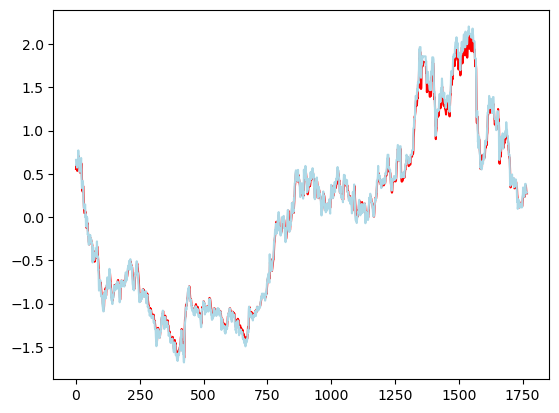

In [13]:
plt.plot(train_results['Train Predictions'][:], color= 'red')
plt.plot(train_results['Actuals'][:], color= 'lightblue')

Now for future forecasting, we first set how many days we want to forecast then extend out dates dataframe to that many days.

We set our prediction to account for the last 45 days (in this case) to predict as many future days.

(Use a rolling dataset next time)

In [34]:
future_days=45
forecast_date=pd.date_range(list(train_dates)[-1], periods=future_days, freq='1d').tolist()
forecast=model.predict(train_X[-future_days:])

2/2 [==============================] - 0s 4ms/step


As LSTM requires the same shape in the input as before, while predicting future dates there is a problem of not having all columns of data. So, a quick fix is to take repeated column to fulfill the shape required and then only consider 1 column in the output.

We also rescale our previously scaled down values back.

In [35]:
forecast_copied=np.repeat(forecast, X.shape[1], axis=-1)
y_pred_futures=scaler.inverse_transform(forecast_copied)[:, 0]

In [36]:
dates=[]
for i in forecast_date:
    dates.append(i.date())

In [37]:
df_forecast=pd.DataFrame({'Date': np.array(dates), 'Open': y_pred_futures})

In [38]:
df_forecast.head()

,Date,Open
0,2024-06-21,19.393311
1,2024-06-22,19.402695
2,2024-06-23,19.353024
3,2024-06-24,19.188511
4,2024-06-25,19.136889


In [39]:
original=df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
original=original.loc[original['date']>='2024-02-01']

C:\Users\Hp\AppData\Local\Temp\ipykernel_2876\1739352854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


<Axes: xlabel='date', ylabel='open'>

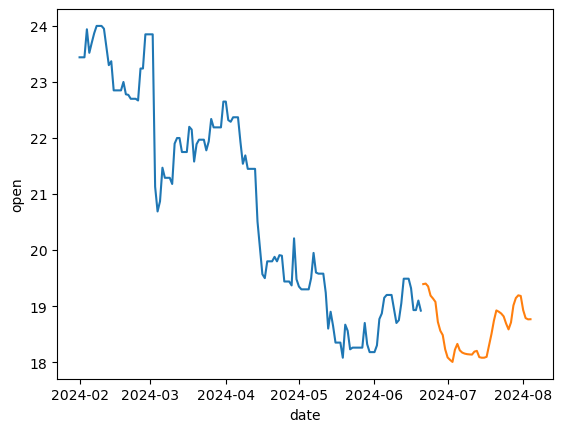

In [40]:
sns.lineplot(x=original['date'], y= original['open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])